#### Import necessary modules for training a model

In [1]:
%matplotlib inline
from __future__ import division, print_function
import os
from collections import OrderedDict
import numpy as np
np.random.seed(0) # for reproducibility

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#### Load and preprocess the data

In [2]:
import h5py
import keras
from keras.datasets import imdb
print("Keras version:",keras.__version__)
from keras.preprocessing import sequence

max_features = 5000
maxlen = 400

print('Loading data...')
(X_set1, y_set1), (X_set2, y_set2) = imdb.load_data(num_words=max_features)
print(len(X_set1)+len(X_set2), ' sequences')

print('Pad sequences (samples x time)')
X_set1 = sequence.pad_sequences(X_set1, maxlen=maxlen)
X_set2 = sequence.pad_sequences(X_set2, maxlen=maxlen)

Keras version: 2.1.4
Loading data...
50000  sequences
Pad sequences (samples x time)


Using TensorFlow backend.


#### Split the training set into a training and validation set

In [3]:
X_train = X_set1[5000:]
y_train = y_set1[5000:]
X_valid = np.concatenate((X_set1[:5000], X_set2[:5000]), axis=0)
y_valid = np.concatenate((y_set1[:5000], y_set2[:5000]), axis=0)
X_test = X_set2[5000:]
y_test = y_set2[5000:]
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)
print('X_test shape:', X_test.shape)

X_train shape: (20000, 400)
X_valid shape: (10000, 400)
X_test shape: (20000, 400)


In [4]:
#### Download model and load it
!./grab_model.sh

# Building the model architecture that ships with Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D

batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 2

model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

#load pretrained weights
model.load_weights("imdb_model.h5")

File imdb_model.h5 exists already


#### Compute model outputs (with and without test-time dropout) on the validation set

In [5]:
import abstention as ab

num_dropout_runs = 20 #the number of runs to use with test-time dropout
batch_size = 50
task_idx = 0 #output task to evaluate abstention metrics for

#preact_func returns the output prior to the final sigmoid nonlinearity, given the input
preact_func = ab.util.get_preact_func(model=model, task_idx=task_idx)

#Compute the output on the validation set pre-activation, both without test-time
#dropout and with test-time dropout enabled
print("On validation set")
valid_preacts, valid_dropout_preacts = ab.util.obtain_raw_data(
    preact_func=preact_func,
    data=X_valid,
    num_dropout_runs=num_dropout_runs,
    batch_size=batch_size)

#Do the same for the testing set
print("On testing set")
test_preacts, test_dropout_preacts = ab.util.obtain_raw_data(
    preact_func=preact_func, data=X_test, num_dropout_runs=num_dropout_runs, batch_size=batch_size)

On validation set
Computing deterministic activations
Computing nondeterministic activations
Done 10 runs
Done 20 runs
On testing set
Computing deterministic activations
Computing nondeterministic activations
Done 10 runs
Done 20 runs


#### Put model outputs through calibration

In [6]:
cb_method_name_to_factory = OrderedDict([
    #Expit is just the sigmoid; no calibration
    ("uncalibrated_posterior", ab.calibration.Expit()),
    ("platt_calibrated_posterior", ab.calibration.PlattScaling()),
    #For isotonic regression, uncomment the line below:
    #("ir_calibrated_posterior", ab.calibration.IsotonicRegression()),
])

(cb_method_name_to_valid_posterior_prob,
 cb_method_name_to_test_posterior_prob,
 transform_name_to_valid_uncert,
 transform_name_to_test_uncert) =\
    ab.util.obtain_posterior_probs_and_uncert_estimates(
        cb_method_name_to_factory=cb_method_name_to_factory,
        valid_labels=y_valid,
        valid_preacts=valid_preacts,
        valid_dropout_preacts=valid_dropout_preacts,
        test_preacts=test_preacts,
        test_dropout_preacts=test_dropout_preacts)

Platt scaling coef: 1.18355433036 ; intercept: -0.797542838195


`cb_method_name_to_valid_posterior_prob` and `cb_method_name_to_test_posterior_prob` have keys of:
- `uncalibrated_posterior` which has the uncalibrated (i.e.) the original probabilities
- `platt_calibrated_posterior` which has the calibrated probabilities using platt scaling

`transform_name_to_valid_uncert` and `transform_name_to_test_uncert` have keys of:
- `preactivation_uncertainty`, which has the population standard deviation computed on the output before the final nonlinearity
- `uncalibrated_posterior_uncertainty`, which has the population standard deviation computed on the uncertainties output after the final nonlinearity, but without any calibration applied
- `platt_calibrated_posterior_uncertainty`, which has the population standard deviation computed on the uncertainties output after the final nonlinearity and after calibration is applied using Platt scaling

We can observe the quality of the calibration by plotting a calibration curve:

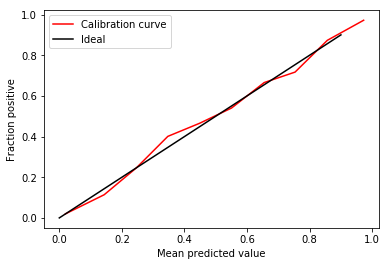

In [7]:
from matplotlib import pyplot as plt
import sklearn.calibration

platt_frac_pos, platt_mean_pred_val = sklearn.calibration.calibration_curve(
        y_true=y_valid,
        y_prob=cb_method_name_to_valid_posterior_prob['platt_calibrated_posterior'],
        normalize=False, n_bins=10)

handles = []
handles.append(plt.plot(platt_mean_pred_val, platt_frac_pos, color="red")[0])
handles.append(plt.plot(np.arange(0,1,0.1), np.arange(0,1,0.1), color="black")[0])
plt.ylabel("Fraction positive")
plt.xlabel("Mean predicted value")
plt.legend(handles, ["Calibration curve", "Ideal"])
plt.show()

#### Instantiate and run the abstention methods


Calling method random


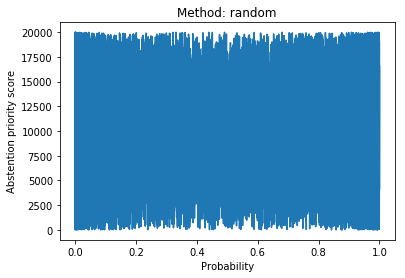


Calling method calibrated_marginal_auroc
valid est metric 0.972389949749
data est metric 0.968088482924


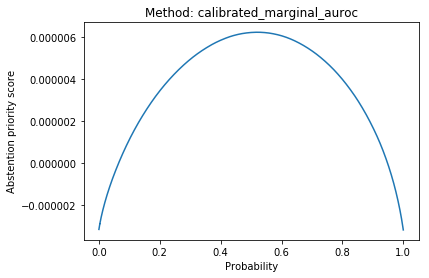


Calling method calibrated_marginal_auprc
valid est metric 0.970457237851
data est metric 0.966376810871


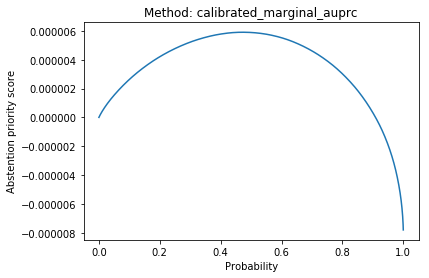


Calling method uncalibrated_prob_distance_point_five


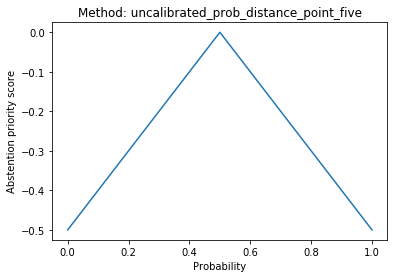


Calling method calibrated_prob_distance_point_five


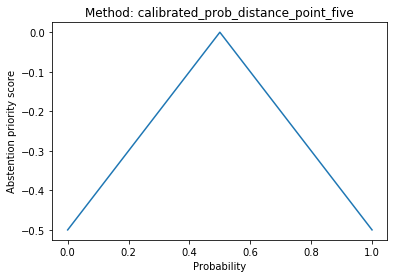


Calling method preactivation_uncertainty


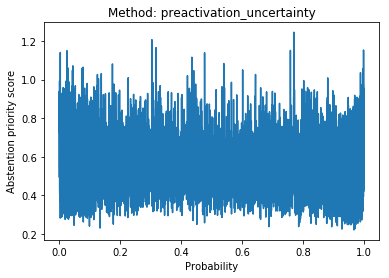


Calling method uncalibrated_posterior_uncertainty


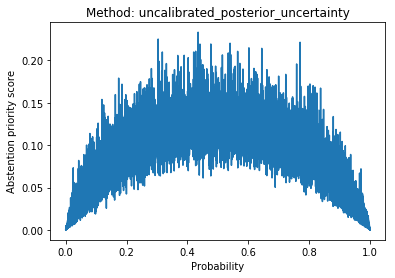


Calling method calibrated_posterior_uncertainty


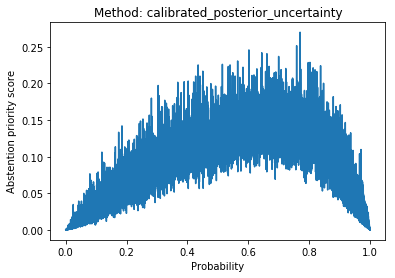

In [8]:
import abstention
reload(abstention.abstention)
from abstention.abstention import AuPrcAbstentionEval, AuRocAbstentionEval
from abstention.abstention import (FixedThreshold, RandomAbstention,
                                   NegPosteriorDistanceFromThreshold,
                                   Uncertainty,
                                   MarginalDeltaAuRoc, MarginalDeltaAuPrc,
                                   RecursiveMarginalDeltaAuRoc,
                                   RecursiveMarginalDeltaAuPrc)
from collections import namedtuple

#AbstentionFuncInfo is just a tuple to store
#information about the abstention method
AbstentionFuncInfo = namedtuple('AbstentionFuncInfo',
                                ('method_name', 'factory', 'posterior', 'uncert'))

#We will evaluate the abstention quality though auROC and
#auPRC after evicting 5% and 20% of the examples
evaluation_functions = OrderedDict([('auPRC_0.95',AuPrcAbstentionEval(0.95)),
                                    ('auROC_0.95',AuRocAbstentionEval(0.95)),
                                    ('auPRC_0.8',AuPrcAbstentionEval(0.8)),
                                    ('auROC_0.8',AuRocAbstentionEval(0.8))])

#Prepare an array storing all the different abstention approaches we will try
abstention_func_infos = [
    
         #random abstention
         AbstentionFuncInfo(method_name='random', factory=RandomAbstention(),
                            posterior='platt_calibrated_posterior', uncert=None),
    
         #Curve optimization methods
         #marginal auROC curve optimization
         AbstentionFuncInfo(method_name='calibrated_marginal_auroc',
                            factory=MarginalDeltaAuRoc(),
                            posterior='platt_calibrated_posterior', uncert=None),
         #marginal auPRC curve optimization
         AbstentionFuncInfo(method_name='calibrated_marginal_auprc',
                            factory=MarginalDeltaAuPrc(),
                            posterior='platt_calibrated_posterior', uncert=None),
    
         #To use the recursive versions of the curve optimization functions,
         #uncomment below. Note: these methods are designed to correct for the
         #change in class imbalance that may occur as examples are evicted. They
         #rely on good calibration to correctly judge what that change in imbalance
         #may be. They are also a lot slower.
         #AbstentionFuncInfo(method_name='recursive_calibrated_marginal_auroc',
         #                   factory=RecursiveMarginalDeltaAuRoc(proportion_to_retain=0.8),
         #                   posterior='platt_calibrated_posterior', uncert=None),
         #AbstentionFuncInfo(method_name='recursive_calibrated_marginal_auprc',
         #                   factory=RecursiveMarginalDeltaAuPrc(proportion_to_retain=0.8),
         #                   posterior='platt_calibrated_posterior', uncert=None),
    
         #Distance of probability from 0.5 threshold
         #Distance of the uncalibrated probability prediction from 0.5
         AbstentionFuncInfo(method_name='uncalibrated_prob_distance_point_five',
                            factory=NegPosteriorDistanceFromThreshold(FixedThreshold(0.5)),
                            posterior='uncalibrated_posterior', uncert=None),
         #Distance of the calibrated probability prediction from 0.5
         AbstentionFuncInfo(method_name='calibrated_prob_distance_point_five',
                            factory=NegPosteriorDistanceFromThreshold(FixedThreshold(0.5)),
                            posterior='platt_calibrated_posterior', uncert=None),
    
         #Test-time dropout methods
         #Population standard deviation of activations before the nonlinearity
         AbstentionFuncInfo(method_name='preactivation_uncertainty',
                            factory=Uncertainty(),
                            posterior='uncalibrated_posterior',
                            uncert='preactivation'),
         #Population standard deviation uncalibrated probabilities
         AbstentionFuncInfo(method_name='uncalibrated_posterior_uncertainty',
                            factory=Uncertainty(),
                            posterior='uncalibrated_posterior',
                            uncert='uncalibrated_posterior'),
         #Population standard deviation of calibrated probabilities
         AbstentionFuncInfo(method_name='calibrated_posterior_uncertainty',
                            factory=Uncertainty(),
                            posterior='uncalibrated_posterior',
                            uncert='platt_calibrated_posterior')]

metric_to_method_name_to_test_perfs = OrderedDict()
for metric_name in evaluation_functions:
    method_name_to_test_perfs = OrderedDict([
            (abstention_func.method_name, []) for abstention_func in abstention_func_infos])
    metric_to_method_name_to_test_perfs[metric_name] = method_name_to_test_perfs

for abstention_func_info in abstention_func_infos:
    print("\nCalling method", abstention_func_info.method_name)
    
    factory = abstention_func_info.factory
    posterior_name = abstention_func_info.posterior
    uncert_name = abstention_func_info.uncert   

    valid_posterior = cb_method_name_to_valid_posterior_prob[posterior_name]
    test_posterior = cb_method_name_to_test_posterior_prob[posterior_name]
    valid_uncert = transform_name_to_valid_uncert[uncert_name] if uncert_name else None
    test_uncert = transform_name_to_test_uncert[uncert_name] if uncert_name else None
    
    #The abstention factor takes the validation labels, probabilities
    #and uncertainty estimates (some of these may be None depending on the method)
    #and returns abstention_func, which accepts the test probabilities
    #and uncertainties and returns abstention priority scores
    #(higher scores are evicted sooner)
    abstention_func = factory(valid_labels=y_valid,
                              valid_posterior=valid_posterior,
                              valid_uncert=valid_uncert)
    test_abstention_scores = abstention_func(posterior_probs=test_posterior,
                                             uncertainties=test_uncert)
    
    plt.plot(*zip(*sorted(zip(test_posterior, test_abstention_scores),
                     key=lambda x: x[0])))
    plt.ylabel("Abstention priority score")
    plt.xlabel("Probability")
    plt.title("Method: "+abstention_func_info.method_name)
    plt.show()
    
    for evaluation_func_name, evaluation_func in evaluation_functions.items():
        test_perf = evaluation_func(abstention_scores=test_abstention_scores,
                                    y_true=y_test, y_score=test_posterior)
        metric_to_method_name_to_test_perfs[evaluation_func_name]\
                                      [abstention_func_info.method_name].append(test_perf)

#### Print the ranked results

In [9]:
from collections import defaultdict

for metric_name in ["auROC_0.95", "auPRC_0.95"]:

    print("\nBest "+metric_name+" methods - test")
    metric_to_test_score = defaultdict(lambda: 0)
    metric_name_ranks = sorted(
        metric_to_method_name_to_test_perfs[metric_name].keys(),
        key=lambda x: -metric_to_method_name_to_test_perfs[metric_name][x][0])
    for idx, name in enumerate(metric_name_ranks):
            metric_to_test_score[name] += idx
    print(metric_name+" ranks:")
    print("\n".join(str(x[0])+":\n\t"+metric_name+": "
                    +str(np.mean(metric_to_method_name_to_test_perfs[metric_name][x[0]]))
                    +", rank: "+str(len(metric_to_test_score)-x[1])
                    for x in sorted(metric_to_test_score.items(), key=lambda x: x[1])))


Best auROC_0.95 methods - test
auROC_0.95 ranks:
calibrated_marginal_auroc:
	auROC_0.95: 0.960986741482, rank: 8
calibrated_prob_distance_point_five:
	auROC_0.95: 0.960984774081, rank: 7
calibrated_marginal_auprc:
	auROC_0.95: 0.960962693664, rank: 6
calibrated_posterior_uncertainty:
	auROC_0.95: 0.960701727434, rank: 5
uncalibrated_posterior_uncertainty:
	auROC_0.95: 0.96004541727, rank: 4
uncalibrated_prob_distance_point_five:
	auROC_0.95: 0.959972142762, rank: 3
preactivation_uncertainty:
	auROC_0.95: 0.955195011382, rank: 2
random:
	auROC_0.95: 0.95431314173, rank: 1

Best auPRC_0.95 methods - test
auPRC_0.95 ranks:
calibrated_marginal_auprc:
	auPRC_0.95: 0.959027337856, rank: 8
calibrated_prob_distance_point_five:
	auPRC_0.95: 0.958986344557, rank: 7
calibrated_marginal_auroc:
	auPRC_0.95: 0.958982371416, rank: 6
calibrated_posterior_uncertainty:
	auPRC_0.95: 0.958803299793, rank: 5
uncalibrated_posterior_uncertainty:
	auPRC_0.95: 0.958679585606, rank: 4
uncalibrated_prob_distanc